In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import os
from pathlib import Path
from sklearn.model_selection import train_test_split
from google.colab import drive
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from concurrent.futures import ProcessPoolExecutor
import logging
from sklearn.feature_selection import SelectFromModel
from joblib import Parallel, delayed
import matplotlib
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV


In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df=pd.read_csv('/content/drive/My Drive/archive/bird_songs_metadata.csv')
df.head()

,id,genus,species,subspecies,name,recordist,country,location,latitude,longitude,altitude,sound_type,source_url,license,time,date,remarks,filename
0,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-0.wav
1,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-1.wav
2,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-4.wav
3,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-5.wav
4,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-6.wav


In [5]:
# List for storing the filepaths and labels
file_paths = []
labels = []
audio_dir = '/content/drive/MyDrive/archive/wavfiles/'

for filename, species in df[['filename', 'species']].itertuples(index=False):
    file_path = Path(audio_dir) / filename
    if file_path.exists():
        file_paths.append(str(file_path))
        labels.append(species)
    else:
        print(f"File not found: {file_path}")

#first five elements of each list
print(file_paths[:5])
print(labels[:5])

['/content/drive/MyDrive/archive/wavfiles/557838-0.wav', '/content/drive/MyDrive/archive/wavfiles/557838-1.wav', '/content/drive/MyDrive/archive/wavfiles/557838-4.wav', '/content/drive/MyDrive/archive/wavfiles/557838-5.wav', '/content/drive/MyDrive/archive/wavfiles/557838-6.wav']
['bewickii', 'bewickii', 'bewickii', 'bewickii', 'bewickii']


In [38]:
# Function to load and process audio files
def load_and_process_audio(file_paths, sr, fixed_length):
    processed_audio = []
    for file_path in file_paths:
        try:
            audio, _ = librosa.load(file_path, sr=sr)
            if len(audio) > fixed_length:
                audio = audio[:fixed_length]
            else:
                audio = np.pad(audio, (0, max(0, fixed_length - len(audio))), 'constant')
            processed_audio.append(audio)
        except Exception as e:
            print(f"Error processing {file_path}: {e}")
    return np.array(processed_audio)

In [39]:
# Function to extract MFCC features
def extract_features(audio_clips, sr, n_mfcc=13):
    def process_sound(sound):
        mfcc = librosa.feature.mfcc(y=sound, sr=sr, n_mfcc=n_mfcc)
        mfcc_scaled = np.mean(mfcc.T, axis=0)
        return mfcc_scaled

    mfcc_features = Parallel(n_jobs=-1)(delayed(process_sound)(sound) for sound in audio_clips)
    return np.array(mfcc_features)

# Function to normalize features
def normalize_features(features):
    mean = np.mean(features, axis=0)
    std = np.std(features, axis=0)
    return (features - mean) / std

In [9]:
if __name__ == "__main__":
    # Variables
    fixed_length = 5 * 22050  # 5 seconds
    sr = 22050

    # Load and process audio files
    processed_audio = load_and_process_audio(file_paths, sr, fixed_length)

    # Extract features
    features = extract_features(processed_audio, sr)

    # Normalize features
    features = normalize_features(features)

    # Encode labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(labels)

    # Train-test split
    X_train, X_test, y_train, y_test, files_train, files_test = train_test_split(
        features, y_encoded, file_paths, test_size=0.2, random_state=42
    )

In [10]:
# Instatiate XGBClassifier
xg_model=XGBClassifier(random_state=42)

In [11]:
# Inspect the parameters
xg_model.get_params()

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': 42,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [12]:
xg_model.set_params(n_estimators=100, booster='gbtree')

xg_model.fit(X_train, y_train)

# Predict on the test set
y_pred = xg_model.predict(X_test)

In [13]:
# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8912442396313364


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

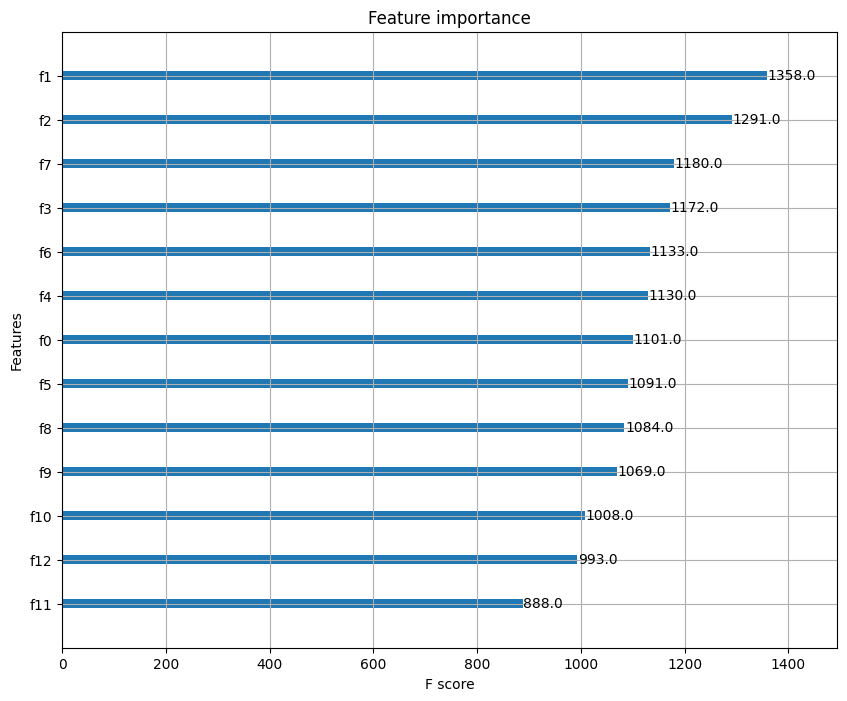

In [40]:
matplotlib.rcParams['figure.figsize'] = (10.0, 8)
xgb.plot_importance(xg_model)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

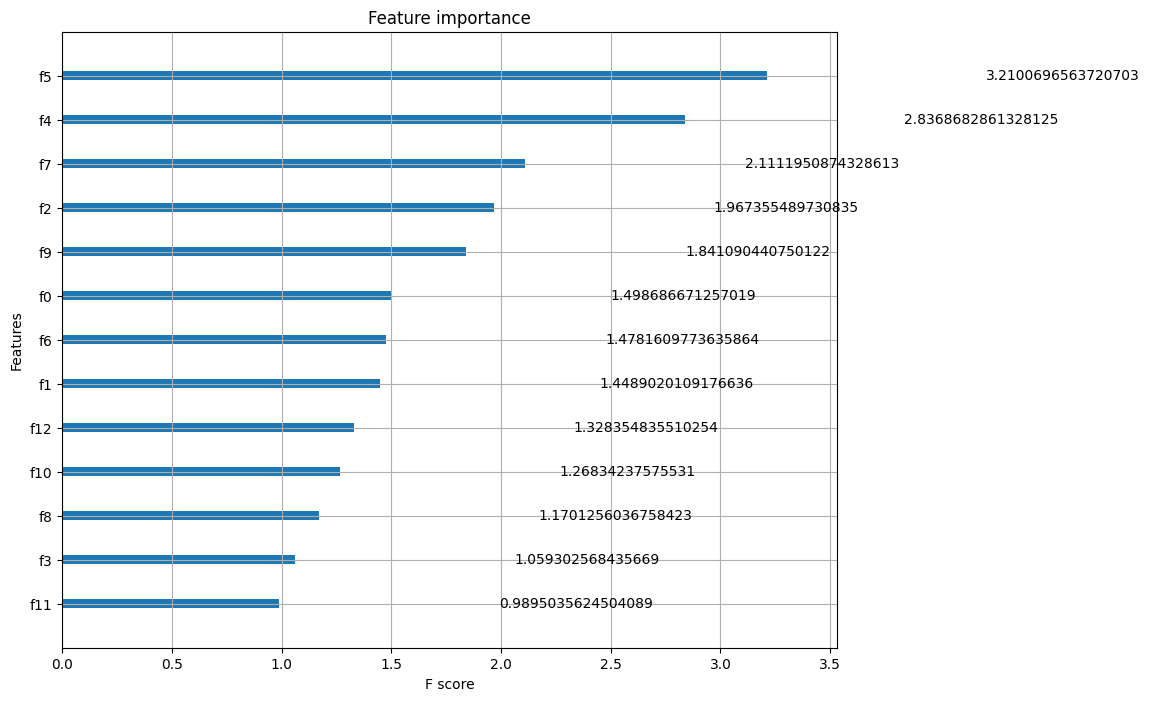

In [34]:
matplotlib.rcParams['figure.figsize'] = (10.0, 8)

xgb.plot_importance(xg_model, importance_type='gain')

<Axes: >

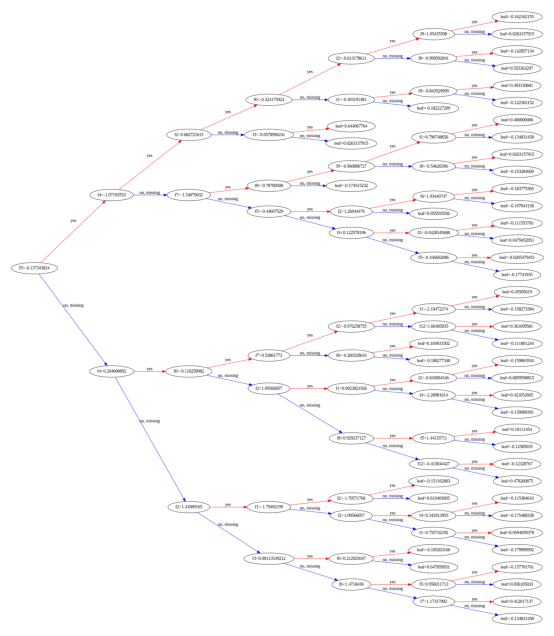

In [35]:
# Plot tree
matplotlib.rcParams['figure.figsize'] = (10.0, 8)

xgb.plot_tree(xg_model, num_trees=0, rankdir='LR')


In [29]:
# Define a parameter grid
rs_param_grid = {
    'max_depth': list((range(3,12))),
    'alpha': [0,0.001, 0.01,0.1,1],
    'subsample': [0.5,0.75,1],
    'learning_rate': np.linspace(0.01,0.5, 10),
    'n_estimators': [10, 25, 40]
    }


In [37]:
# Insantiate XGBoost Clasifier
xgb_model2 = XGBClassifier(random_state=42)

# Instantiate RandomizedSearchCV
xgb_rs = RandomizedSearchCV(estimator=xgb_model2,param_distributions=rs_param_grid,
                                cv=3, n_iter=5, verbose=2, random_state=42)

# Train the model
xgb_rs.fit(X_train, y_train)

#best parameters and highest accuracy
print("Best parameters found: ", xgb_rs.best_params_)
print("Best accuracy found: ", xgb_rs.best_score_)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END alpha=0.1, learning_rate=0.5, max_depth=4, n_estimators=40, subsample=0.5; total time=   0.4s
[CV] END alpha=0.1, learning_rate=0.5, max_depth=4, n_estimators=40, subsample=0.5; total time=   0.6s
[CV] END alpha=0.1, learning_rate=0.5, max_depth=4, n_estimators=40, subsample=0.5; total time=   0.9s
[CV] END alpha=1, learning_rate=0.17333333333333334, max_depth=5, n_estimators=40, subsample=0.5; total time=   1.3s
[CV] END alpha=1, learning_rate=0.17333333333333334, max_depth=5, n_estimators=40, subsample=0.5; total time=   0.5s
[CV] END alpha=1, learning_rate=0.17333333333333334, max_depth=5, n_estimators=40, subsample=0.5; total time=   0.5s
[CV] END alpha=0.001, learning_rate=0.01, max_depth=8, n_estimators=25, subsample=1; total time=   1.0s
[CV] END alpha=0.001, learning_rate=0.01, max_depth=8, n_estimators=25, subsample=1; total time=   1.0s
[CV] END alpha=0.001, learning_rate=0.01, max_depth=8, n_estimators=25, 